In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else "cpu"
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [2]:
print(device)

cuda


In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# MNIST train set
mnist_train = dsets.MNIST(root = 'MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root = 'MNIST_data/',
                          train = False,
                          transform = transforms.ToTensor(),
                          download=True)

In [5]:
# data loader
data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                     batch_size= batch_size,
                                     shuffle = True,
                                     drop_last = True) 

In [6]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = nn.Sequential(nn.Conv2d(32,64,kernel_size=3, stride=1, padding= 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = nn.Linear(7*7*64,10,bias = True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # batch size * flatten size
        out = self.fc(out)
        return out

In [7]:
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [9]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X,Y in data_loader:
        # image size = 이미 28*28
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print("Epoch: {:>4} cost = {:>.9}".format(epoch+1, avg_cost))

print("Learning Finished")

Epoch:    1 cost = 0.223933265
Epoch:    2 cost = 0.0620889738
Epoch:    3 cost = 0.0448874719
Epoch:    4 cost = 0.0354991555
Epoch:    5 cost = 0.0290388148
Epoch:    6 cost = 0.0248126648
Epoch:    7 cost = 0.0207077824
Epoch:    8 cost = 0.0179347582
Epoch:    9 cost = 0.0151069155
Epoch:   10 cost = 0.0124752792
Epoch:   11 cost = 0.0106111132
Epoch:   12 cost = 0.00969583262
Epoch:   13 cost = 0.00816990249
Epoch:   14 cost = 0.0078718802
Epoch:   15 cost = 0.00576935476
Learning Finished


Acc = 0.9876999855041504
torch.Size([1, 1, 28, 28])
Label : 2
Prediction : 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


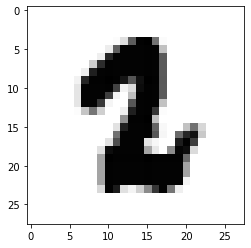

In [10]:
# test
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print(f'Acc = {accuracy.item()}')

    # visualization
    r = random.randint(0,len(mnist_test)-1)
    X_Single_data = mnist_test.test_data[r].view(1,1,28,28).float().to(device)
    print(X_Single_data.shape)
    Y_Single_data = mnist_test.test_labels[r].to(device)
    Single_prediction = model(X_Single_data)
    print(f"Label : {Y_Single_data.item()}")
    print(f"Prediction : {torch.argmax(Single_prediction,1).item()}")
    plt.imshow(mnist_test.test_data[r], cmap='Greys', interpolation='nearest')
    plt.show()